In [1]:
#!/usr/bin/env python3.7
# -*- coding: utf-8 -*-
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/data/rfm_data.csv')

In [3]:
data.describe()

,delta_last_order_date,orders_total,gmv_total
count,500000.000000,500000.000000,5.000000e+05
mean,83.467054,118.049134,2.891969e+09
std,52.230729,110.094428,4.740971e+09
min,20.000000,10.000000,1.990450e+05
25%,43.000000,60.000000,7.174699e+08
50%,67.000000,96.000000,1.467198e+09
75%,120.000000,133.000000,3.255968e+09
max,222.000000,6242.000000,5.389788e+11


In [4]:
data.columns

Index(['user_id', 'delta_last_order_date', 'orders_total', 'gmv_total'], dtype='object')

In [5]:
data[['user_id', 'delta_last_order_date', 'orders_total', 'gmv_total']].head()

,user_id,delta_last_order_date,orders_total,gmv_total
0,9dea0a456345c6f66337bdb92934f552,80,183,5960359585
1,8def67d5d76ce2872ac16b7693f10313,189,134,1443155755
2,389381cff07efe5833fac9ede610fea8,113,132,4799903425
3,95a4636240488fda6b7f0498de5924ae,64,88,801619045
4,76978d5e13d9daee315d8d062ed15901,46,21,351221005


In [6]:
data = data.rename(columns={'delta_last_order_date': 'Recency',
                            'orders_total': 'Frequency', 
                            'gmv_total': 'Monetory'})

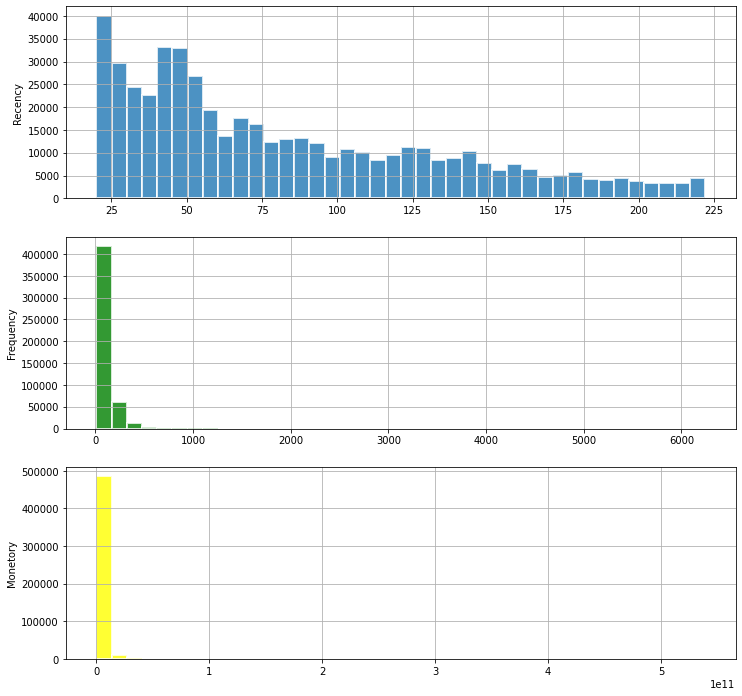

In [7]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

## Реализуем 2 варианта:
### 1. Квантильный RFM:

In [8]:
def rfm_quantile(rfm_data: pd.DataFrame() = None, metrics: list() = None, q: int = 4):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns[1:]
    Recency, Frequency, Monetary = metrics
    rfm_data[metrics] = rfm_data[metrics].dropna().astype('int64')

    labels = range(q, 0, -1)
    rfm_data['R'] = pd.qcut(rfm_data[Recency], q=q, labels=labels).values
    rfm_data['F'] = pd.qcut(rfm_data[Frequency], q=q, labels=labels[::-1]).values
    rfm_data['M'] = pd.qcut(rfm_data[Monetary], q=q, labels=labels[::-1]).values
    rfm_data['RFM_Segment'] = rfm_data.apply(lambda x: str(x['R']) +
                                                       str(x['F']) +
                                                       str(x['M']), axis=1)
    rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)
    return rfm_data

In [9]:
rfm_result = rfm_quantile(data, metrics = ['Recency', 'Frequency', 'Monetory'], q = 4)

In [10]:
rfm_result.head()

,user_id,Recency,Frequency,Monetory,R,F,M,RFM_Segment,RFM_Score
0,9dea0a456345c6f66337bdb92934f552,80,183,5960359585,2,4,4,244,10
1,8def67d5d76ce2872ac16b7693f10313,189,134,1443155755,1,4,2,142,7
2,389381cff07efe5833fac9ede610fea8,113,132,4799903425,2,3,4,234,9
3,95a4636240488fda6b7f0498de5924ae,64,88,801619045,3,2,2,322,7
4,76978d5e13d9daee315d8d062ed15901,46,21,351221005,3,1,1,311,5


In [11]:
rfm = rfm_result[['RFM_Score', 'user_id']].groupby(['RFM_Score']).user_id.nunique().reset_index().rename({'user_id': 'users'}, axis = 1)
rfm.head(10)

,RFM_Score,users
0,3,20791
1,4,43864
2,5,62072
3,6,73491
4,7,66941
5,8,56182
6,9,45201
7,10,41174
8,11,50020
9,12,38615


<AxesSubplot:xlabel='RFM_Score', ylabel='users'>

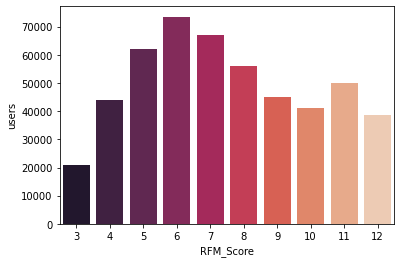

In [12]:
sns.barplot(data = rfm, x = 'RFM_Score', y = 'users', palette = "rocket")

<AxesSubplot:ylabel='Count'>

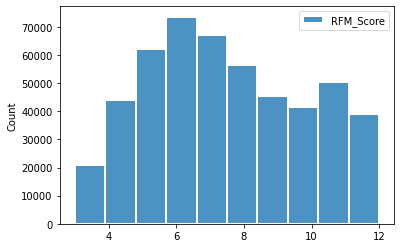

In [13]:
sns.histplot(data = rfm_result[['user_id', 'RFM_Score']], bins = 10, alpha=0.8, edgecolor='white', linewidth=2)

In [14]:
rfm_aggr = rfm_result[['user_id', 'R', 'F']].groupby(['R', 'F']).user_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'user_id', index='R', columns='F')

<AxesSubplot:xlabel='F', ylabel='R'>

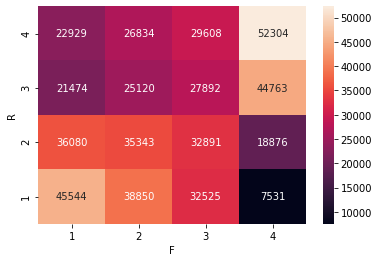

In [15]:
sns.heatmap(rfm_pivot, annot=True, fmt=".0f")

<AxesSubplot:xlabel='F', ylabel='R'>

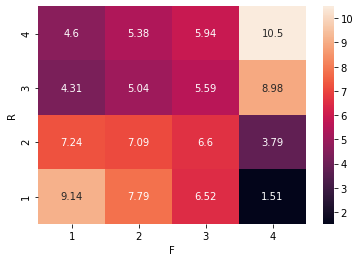

In [16]:
rfm_aggr['users_share'] = rfm_aggr['user_id']*1.0/rfm_aggr['user_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R', columns='F'), annot=True, fmt=".3g")

### 2. RFM при помощи kmeans:

### 2.1. Масштабирование данных:

In [17]:
def scale_data(X_train: pd.DataFrame() = None, 
               metrics: list() = None):
    if X_train is None:
        return None
    if metrics is None:
        metrics = X_train.columns[1:]
    Recency, Frequency, Monetary = metrics  # Syntax Sugar
    X_train_scaled = X_train.copy(deep=True)
    X_train_scaled[metrics[1:]] = X_train_scaled[metrics[1:]].dropna().astype('int64')

    # Conforming to the "Standart C99" `np.log(item)` returns `-Inf` value for item <= 0
    # Therefore we should handle it:
    adjust_to_uno = lambda item: 1 if item <= 0 else item
    X_train_scaled[Recency] = X_train_scaled[Recency].apply(adjust_to_uno)
    X_train_scaled[Monetary] = X_train_scaled[Monetary].apply(adjust_to_uno)
    # Unskew the data by logorithm (https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16):
    X_train_scaled[metrics] = X_train_scaled[metrics].apply(np.log, axis=1).round(3)
    return X_train_scaled

In [18]:
data_transformed = scale_data(data[['user_id', 'Recency', 'Frequency', 'Monetory']])

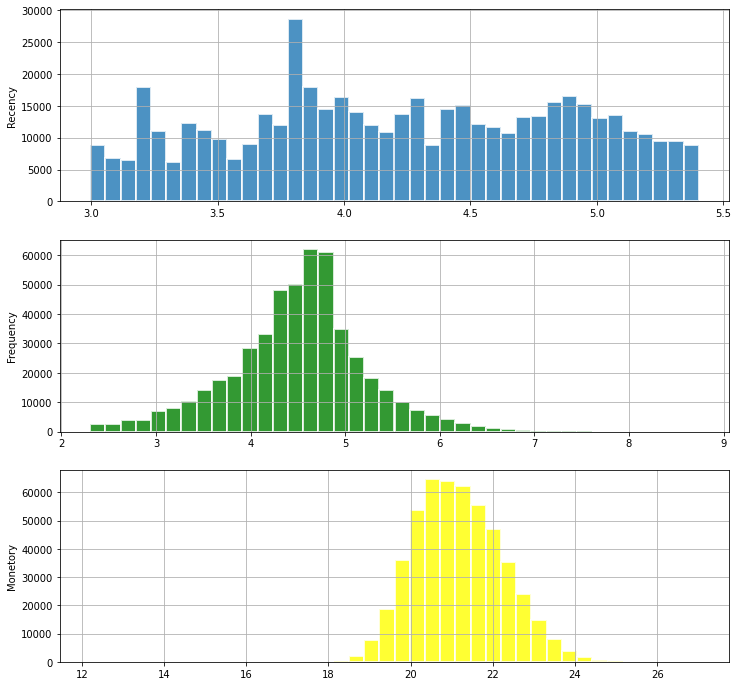

In [19]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data_transformed['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data_transformed['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data_transformed['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

### 2.2. Нормализация данных:

In [20]:
def normalize_data(X_train: pd.DataFrame() = None, metrics: list() = None, name: str = ''):
    if X_train is None:
        return None
    if metrics is None:
        metrics = X_train.columns[1:]
    X_train_scaled = X_train.copy(deep=True)
    X_train_scaled[metrics] = X_train_scaled[metrics].astype('int64')

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler() # StandardScaler() # MaxAbsScaler # MinMaxScaler
    pipe = Pipeline([('imputer', imputer), ('scaler', scaler)])

    X_train_scaled[metrics] = pd.DataFrame(data=pipe.fit_transform(X_train_scaled[metrics]),
                                               columns=metrics)
    return X_train_scaled

In [21]:
data_transformed = normalize_data(data_transformed[['user_id', 'Recency', 'Frequency', 'Monetory']])

In [22]:
data_transformed.describe()

,Recency,Frequency,Monetory
count,5.000000e+05,5.000000e+05,5.000000e+05
mean,2.057980e-16,3.141665e-17,-1.071758e-15
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.485259e+00,-2.583610e+00,-7.867663e+00
25%,-1.049644e+00,2.131086e-02,-6.130342e-01
50%,3.859709e-01,2.131086e-02,2.937943e-01
75%,3.859709e-01,2.131086e-02,2.937943e-01
max,1.821586e+00,5.231154e+00,5.734766e+00


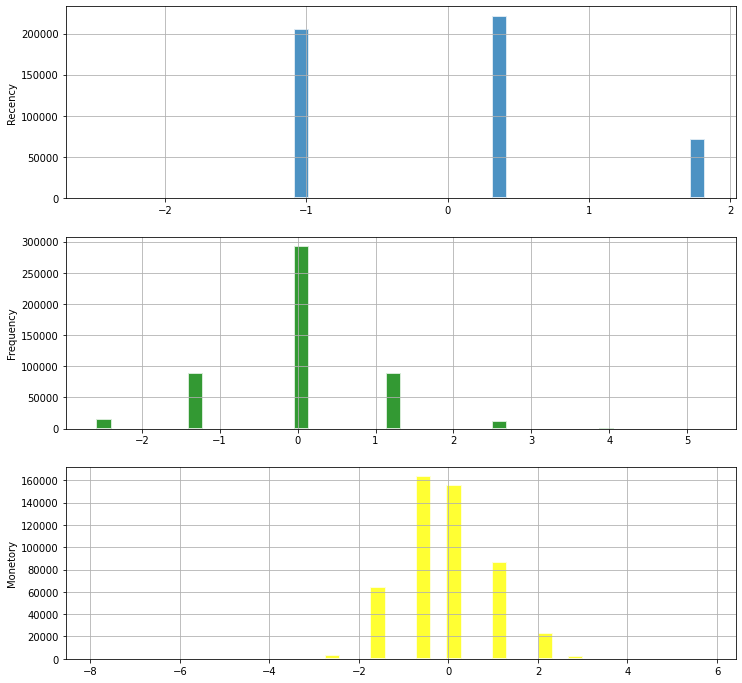

In [23]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data_transformed['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data_transformed['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data_transformed['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

### 2.3. Определение количества кластеров

In [24]:
def wcss(rfm_data: pd.DataFrame() = None, metrics: list() = None):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns

    wcss = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300)
        kmeans.fit(rfm_data)
        wcss[k] = kmeans.inertia_
    # plot the WCSS values
    sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
    plt.xlabel('K Numbers')
    plt.ylabel('WCSS')
    plt.show()
    return

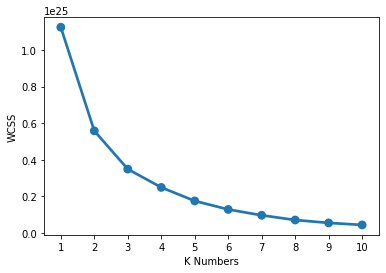

In [25]:
wcss(data[['Recency', 'Frequency', 'Monetory']])

### 2.4. Определение количества кластеров при помощи билиотеки YellowBrick:

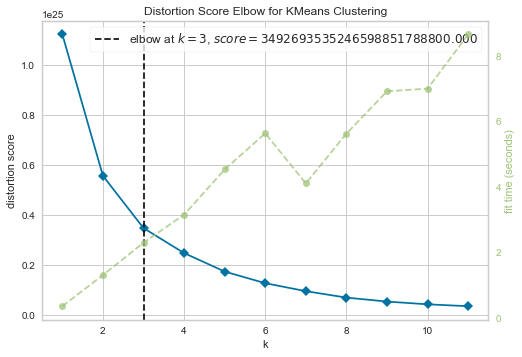

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(data[['Recency', 'Frequency', 'Monetory']]) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

### 2.5. Сегментация при помощи K-Means:

In [27]:
def rfm_knn(rfm_data: pd.DataFrame() = None, metrics: list() = None, name: str = '', n_clusters: int = 4):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns[1:]
    # Сlustering
    Recency, Frequency, Monetary = metrics

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Recency]].dropna().astype('int64'))
    rfm_data['R_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Frequency]].dropna().astype('int64'))
    rfm_data['F_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Monetary]].dropna().astype('int64'))
    rfm_data['M_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[metrics].dropna().astype('int64'))
    # Assign the clusters to datamart
    rfm_data['K_Cluster'] = kmeans_clusters.labels_+1
    return rfm_data

In [28]:
result = rfm_knn(data[['user_id', 'Recency', 'Frequency', 'Monetory']])

In [29]:
result.head()

,user_id,Recency,Frequency,Monetory,R_Cluster,F_Cluster,M_Cluster,K_Cluster
0,9dea0a456345c6f66337bdb92934f552,80,183,5960359585,1,1,3,3
1,8def67d5d76ce2872ac16b7693f10313,189,134,1443155755,3,1,1,1
2,389381cff07efe5833fac9ede610fea8,113,132,4799903425,2,1,3,3
3,95a4636240488fda6b7f0498de5924ae,64,88,801619045,1,4,1,1
4,76978d5e13d9daee315d8d062ed15901,46,21,351221005,4,4,1,1


In [30]:
rfm_aggr = result[['user_id', 'R_Cluster', 'F_Cluster']].groupby(['R_Cluster', 'F_Cluster']).user_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'user_id', index='R_Cluster', columns='F_Cluster')

<AxesSubplot:xlabel='F_Cluster', ylabel='R_Cluster'>

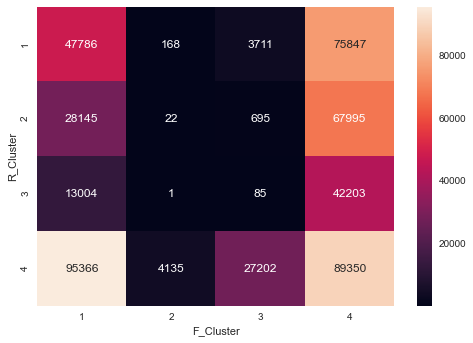

In [31]:
sns.heatmap(rfm_pivot, annot=True, fmt=".0f")

<AxesSubplot:xlabel='F_Cluster', ylabel='R_Cluster'>

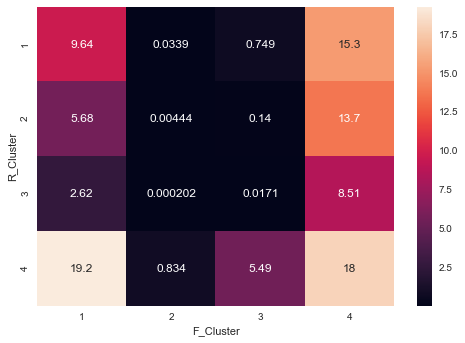

In [32]:
rfm_aggr['users_share'] = rfm_aggr['user_id']*1.0/rfm_aggr['user_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R_Cluster', columns='F_Cluster'), annot=True, fmt=".3g")